<a href="https://colab.research.google.com/github/fsclsnow/AML/blob/master/AML_Project3_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projct 3 - Jiajie Zhu**

CIFAR-10 dataset which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class was used in this project. There are 50,000 training images and 10,000 test images.

This project includes the following features:



*   It performs dimension-reduction (e.g. t-SNE, PCA), and scaling when and if necessary along with justification for each action and comparison of results
*It uses appropriate multiclass classifiers such SVM, Random Forest, K-Nearest Neighbors, etc. comparing ROC curves for the classifiers
*It computes the performance parameters such as confusion matrix, sensitivity, and specificity 
Plots sensitivity and specificity against the number of folds (pick reasonable values for k) in k-fold cross-validation
*It identifies and thoroughly discusses the best classifier based on the obtained results

# Setup

In [0]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
from PIL import Image

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
class_names = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']


# Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i][0]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


Plot a few images to see if data is correct

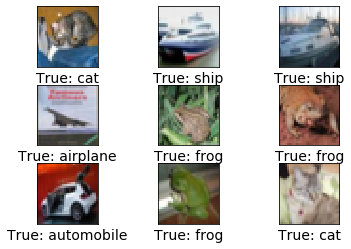

In [0]:
# Get the first images from the test-set.
images = X_test[0:9]

# Get the true classes for those images.
cls_true = y_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

Normalize data range from 0-255 to 0-1 / Similar effect to StandardScaler

In [0]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [0]:
X_train[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

In [0]:
X_train_2d = X_train.reshape(50000,-2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d.astype(np.float64))

In order to perform PCA with 2 dimensional data, we need to lower the dimension of the input data



In [0]:
X_train_2d = X_train.reshape(50000,-2)
X_test_2d=X_test.reshape(10000,-2)
y_train = y_train.ravel()
y_test = y_test.ravel()
X_train_2d.shape, X_test_2d.shape, y_train.shape, y_test.shape

((50000, 3072), (10000, 3072), (50000,), (10000,))

## PCA using Scikit-Learn

In [0]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X_train_2d)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [0]:
cumsum

array([0.29076636, 0.4032979 , 0.47024202, ..., 0.9999992 , 0.9999992 ,
       0.9999992 ], dtype=float32)

In [0]:
d

217

The reduced dimension is 217 instead of 3072 (32 * 32 * 3). Impressive!

Saving figure explained_variance_plot


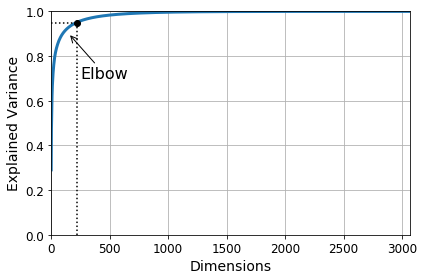

In [0]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 3072, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(150, 0.9), xytext=(250, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [0]:
pca = PCA(n_components=0.95)
X_train_PCA_reduced = pca.fit_transform(X_train_2d)

In [0]:
np.sum(pca.explained_variance_ratio_)

0.950234

t-SNE Dimensionality reduction on the full 50,000 images takes a very long time, so let's only do this on a random subset of 5,000 images:


In [0]:
m = 5000
idx = np.random.permutation(50000)[:m]
X = X_train_2d[idx]
y = y_train[idx]
idx = np.random.permutation(10000)[:m]
X_test_ = X_test_2d[idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X)
X_test_tsne_reduced = tsne.fit_transform(X_test_)

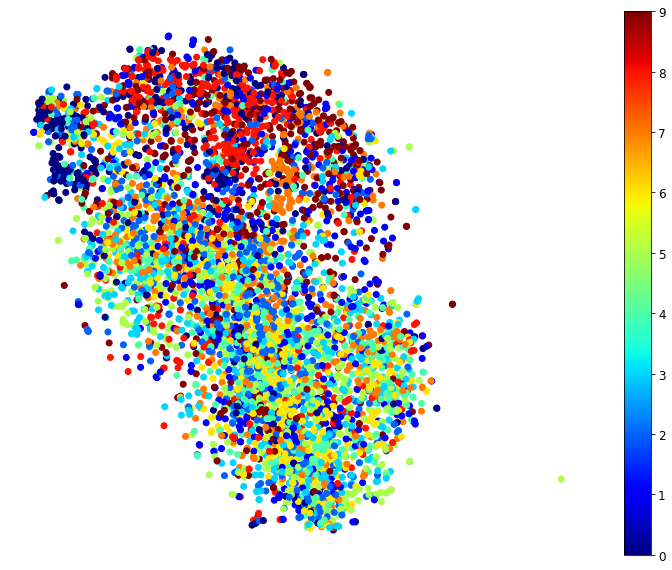

In [0]:
plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

It seems... pretty bad. It's obvious that t-SNE is not able to sperate different clusters.

t-SNE only works well when the data can be reduced to 2 or 3 dimensions.

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [0]:
t0 = time.time()
rnd_clf.fit(X_train_2d, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 276.56s


In [0]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test_2d)
accuracy_score(y_test, y_pred)

0.4654

It tooks almost 5mins, with an accuracy only 46.54%. It seems Random Forest was not a good classifier here.

*Next, use PCA dimension reduced data, with an explained variance ratio of 95%.Train a new Random Forest classifier on the reduced dataset and see how long it takes.*

In [0]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_PCA_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 134.34s


In [0]:
from sklearn.metrics import accuracy_score
X_test_reduced = pca.transform(X_test_2d)
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.4368

It was over 2 times speed up with 2.86% accuracy rate down.

*Measuring Accuracy Using Cross-Validation*

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf2, X_train_PCA_reduced, y_train, cv=3, scoring="accuracy")

array([0.4249715 , 0.41333173, 0.424877  ])

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train_PCA_reduced, y_train):
    clone_rnd_clf = clone(rnd_clf2)
    X_train_folds = X_train_PCA_reduced[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train_PCA_reduced[test_index]
    y_test_fold = y_train[test_index]

    clone_rnd_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_rnd_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.4214315713685726
0.4267114657706846
0.41467658706348254


*Confusion Matrix*

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rnd_clf2, X_train_PCA_reduced, y_train, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[2519,  304,  232,  171,  151,  136,  158,  154,  822,  353],
       [ 217, 2745,   91,  172,   84,  167,  151,  160,  344,  869],
       [ 527,  189, 1422,  392,  887,  376,  556,  275,  214,  162],
       [ 265,  292,  433, 1247,  349, 1005,  585,  281,  201,  342],
       [ 329,  140,  722,  327, 1887,  268,  615,  361,  183,  168],
       [ 197,  229,  418,  927,  388, 1647,  468,  320,  176,  230],
       [ 119,  177,  437,  468,  646,  345, 2376,  155,  105,  172],
       [ 194,  308,  309,  402,  510,  481,  259, 1908,  163,  466],
       [ 615,  410,   83,  176,   94,  188,   82,   77, 2910,  365],
       [ 276, 1019,   67,  169,   82,  192,  150,  241,  412, 2392]])

In [0]:
y_train_perfect_predictions = y_train  # pretend we reached perfection
confusion_matrix(y_train, y_train_perfect_predictions)

array([[5000,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 5000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5000,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5000,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5000,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5000,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5000]])

Specificity (Precision) score

In [0]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred, average='weighted')

0.41681579547072506

Sensitivity (Recall) score

In [0]:
recall_score(y_train, y_train_pred,average='weighted')

0.42106

In [0]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred, average='weighted')

0.4173482980336572

RandomForestClassifier object has no attribute 'decision_function'

Also, from scikit-learn documentation:
recision-recall curves are typically used in binary classification to study the output of a classifier.

Let's try binary classification for label 5

In [0]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [0]:
rnd_clf_5 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf_5.fit(X_train_PCA_reduced, y_train_5)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 148.96s


In [0]:
X_train_PCA_reduced[500].shape

(217,)

In [0]:
rnd_clf_5.predict([X_train_PCA_reduced[500]])

array([ True])

In [0]:
class_names[5]

'dog'

Saving figure some_pic_plot


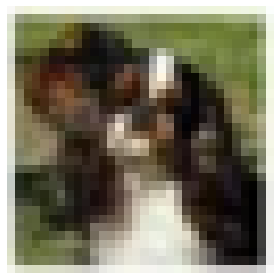

In [0]:
some_pic = X_train_2d[500]
some_pic_image = some_pic.reshape(32, 32, 3)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_pic_plot")
plt.show()

In [0]:
y_scores = cross_val_predict(rnd_clf_5, X_train_PCA_reduced, y_train_5, cv=3)

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_vs_recall_plot


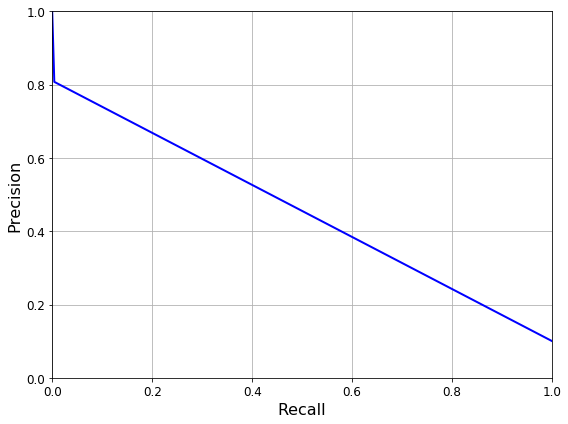

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
# plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
# plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


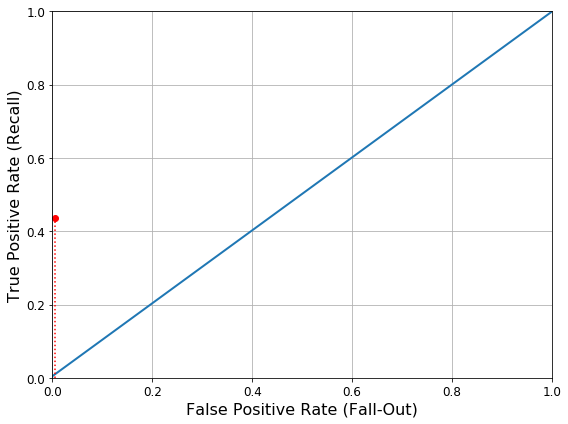

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

RandomForestClassifier object has no attribute 'decision_function'

Also, from scikit-learn documentation:


Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve and average precision to multi-class or multi-label classification, it is necessary to binarize the output. One curve can be drawn per label, but one can also draw a precision-recall curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Receiver Operating Characteristic (ROC):

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Therefore, you should binarize the output and consider precision-recall and roc curves for each class. Moreover, you are going to use predict_proba to get class probabilities.

1. general settings, learning and prediction

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve

Y_roc = label_binarize(y_train, classes=[*range(10)])

clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=50,
                             max_depth=3,
                             random_state=0))
clf.fit(X_train_PCA_reduced, y_train)
y_score = clf.predict_proba(X_test_reduced)


In [0]:
y_score.shape

(10000, 10)

2. precision-recall curve



In [0]:
y_test.shape

(10000,)

In [0]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(10):
    temp = []
    for j in range (len(y_score)):
        temp.append(y_score[j][i])
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i], temp[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

IndexError: ignored

Unfortunatly, I was unable to solve this "IndexError: too many indices for array" as far.
Referenced from: 
https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier/56092736#56092736?newreg=0b5da05e55444f0291309bffc3cd2f53

**The origin codes does not work as well.**

It was supposed to draw 10 individual p vs r curves in one chart for multiclasses.

3. ROC curve

In [0]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  y_score[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

IndexError: ignored

Same as the above cell. Need further research to make it work.

*Next, use t-SNE dimension reduced data, with an explained variance ratio of 95%.Train a new Random Forest classifier on the reduced dataset and see how long it takes.*

In [0]:
rnd_clf3 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf3.fit(X_tsne_reduced, y)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 0.97s


From here we can observed that although t-SNE can siginicantly reduce the training time, but the progress of making the transition took tremendous long time as a trade-off.

In [0]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf3.predict(X_test_tsne_reduced)
accuracy_score(y_test[:5000], y_pred)

0.1028

The accuracy is terribly low.

Let's check the Cross-Validation accuracy and Confusion Matrix for t-SNE reduced Random Forest Classifier.

In [0]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf3, X_test_tsne_reduced, y, cv=3, scoring="accuracy")

array([0.10857828, 0.0959808 , 0.09363745])

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_test_tsne_reduced, y):
    clone_rnd_clf3 = clone(rnd_clf3)
    X_train_folds = X_test_tsne_reduced[train_index]
    y_train_folds = y[train_index]
    X_test_fold = X_test_tsne_reduced[test_index]
    y_test_fold = y[test_index]

    clone_rnd_clf3.fit(X_train_folds, y_train_folds)
    y_pred = clone_rnd_clf3.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.09478104379124175
0.09658068386322735
0.09483793517406963


In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred_rnd_clf3 = cross_val_predict(rnd_clf3, X_test_tsne_reduced, y, cv=3)

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, y_train_pred_rnd_clf3)

array([[55, 46, 58, 49, 47, 44, 36, 56, 41, 44],
       [37, 39, 44, 57, 59, 57, 39, 60, 45, 50],
       [67, 46, 60, 49, 43, 51, 47, 48, 61, 55],
       [50, 60, 58, 50, 46, 51, 50, 59, 54, 45],
       [44, 49, 51, 51, 51, 51, 47, 42, 47, 53],
       [50, 57, 60, 62, 46, 53, 51, 34, 47, 44],
       [48, 49, 54, 49, 43, 60, 42, 52, 42, 46],
       [45, 48, 46, 63, 51, 48, 49, 51, 45, 63],
       [47, 54, 57, 54, 51, 46, 45, 46, 51, 52],
       [46, 59, 56, 52, 59, 58, 37, 43, 45, 45]])

The result is nearly random.

In [0]:
precision_score(y, y_train_pred_rnd_clf3, average='weighted')

0.0994284510727462

In [0]:
recall_score(y, y_train_pred_rnd_clf3,average='weighted')

0.0994

In [0]:
f1_score(y, y_train_pred_rnd_clf3,average='weighted')

0.0993731359346379

From previous examples, we are not going to use t-SNE since it hurts the result too much, also it took too much time for transformation.

# Multiclass classification tests

Saving figure some_pic_plot


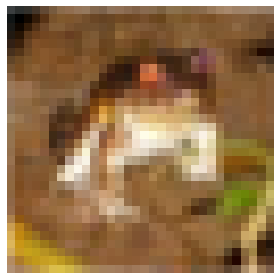

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_pic = X_train_2d[0]
some_pic_image = some_pic.reshape(32, 32, 3)
plt.imshow(some_pic_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_pic_plot")
plt.show()

In [0]:
y[0]

6

In [0]:
class_names[y[0]]

'frog'

This shows a good match from the picture set and its label.

In [0]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train_2d[:1000], y_train[:1000]) # y_train, not y_train_1
svm_clf.predict([some_pic])

array([6], dtype=uint8)

SVM(Support Vector Machine) classifier gave us a prediction of label 6 which is correct.

In [0]:
some_pic_scores = svm_clf.decision_function([some_pic])
some_pic_scores

array([[-0.30416998,  6.24971667,  2.9367128 ,  6.24332789,  8.28665762,
         4.20160149,  9.30097659,  6.23568753,  0.69936942,  1.72025499]])

In [0]:
np.argmax(some_pic_scores)

6

In [0]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
svm_clf.classes_[6]

6

In [0]:
class_names[6]

'frog'

How about using PCA reduced data?

In [0]:
test_reduced = pca.transform([X_train_2d[0]])
svm_clf.fit(X_train_PCA_reduced [:1000], y_train[:1000]) # y_train, not y_train_1
svm_clf.predict(test_reduced)

array([6], dtype=uint8)

In [0]:
some_pic_scores_PCA = svm_clf.decision_function(test_reduced)
some_pic_scores_PCA

array([[ 0.69765411,  6.26273063,  2.72267548,  7.27480863,  8.29047244,
         5.23736714,  9.30374848,  4.21159748, -0.30465832,  1.7290935 ]])

In [0]:
np.argmax(some_pic_scores_PCA)

6

In [0]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [0]:
svm_clf.classes_[6]

6

In [0]:
class_names[6]

'frog'

In [0]:
y_pred = svm_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.3605

PCA reduced data with SVM have an overall accuracy 36.05%

*SVM cross validation, Specificity, Sensitivity Score and Confusion Matrix*

In [0]:
y_train_pred = cross_val_predict(svm_clf, X_train_PCA_reduced, y_train, cv=3)

In [0]:
precision_score(y_train, y_train_pred, average='weighted')

0.5175567885129257

In [0]:
recall_score(y_train, y_train_pred, average='weighted')

0.519

In [0]:
cm_svm = confusion_matrix(y_train, y_train_pred)
cm_svm

array([[2854,  214,  261,  148,  153,  107,  107,  150,  714,  292],
       [ 171, 3166,   93,  170,   71,   91,  114,  135,  274,  715],
       [ 421,  111, 1943,  377,  703,  311,  628,  257,  141,  108],
       [ 182,  140,  454, 1876,  264,  878,  603,  186,  167,  250],
       [ 291,   93,  732,  292, 2096,  239,  660,  352,  134,  111],
       [ 125,  125,  456, 1075,  337, 1917,  440,  285,  122,  118],
       [  71,   88,  409,  447,  541,  248, 2941,  102,   61,   92],
       [ 179,  114,  304,  348,  463,  301,  182, 2733,  105,  271],
       [ 465,  322,   94,  133,  100,  109,   61,   45, 3350,  321],
       [ 211,  733,   84,  166,   64,  110,  129,  153,  276, 3074]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


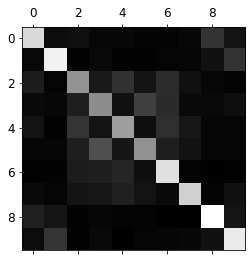

In [0]:
plt.matshow(cm_svm, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Let's try OvR classifier.

In [0]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_2d[:1000], y_train[:1000])
ovr_clf.predict([some_pic])

array([6], dtype=uint8)

In [0]:
len(ovr_clf.estimators_)

10

In [0]:
y_pred = ovr_clf.predict(X_test_2d)
accuracy_score(y_test, y_pred)

0.3267

Overall accuracy for OvR is 32.67%

Let's use PCA reduced data for OvR.

In [0]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_PCA_reduced[:1000], y_train[:1000])
ovr_clf.predict(test_reduced)

array([6], dtype=uint8)

In [0]:
y_pred = ovr_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.3668

Great, PCA reduced data not only speed up the process but also increased accuracy, although it's still lower than RF classifier.

OVR cross validation, Specificity, Sensitivity Score and Confusion Matrix

In [0]:
y_train_ovr_pred = cross_val_predict(ovr_clf, X_train_PCA_reduced, y_train, cv=3)

In [0]:
y_train_ovr_pred

array([6, 1, 9, ..., 9, 8, 7], dtype=uint8)

This takes a very long time, about two hours.

In [0]:
precision_score(y_train, y_train_ovr_pred, average='weighted')

0.5208612397254906

In [0]:
recall_score(y_train, y_train_ovr_pred, average='weighted')

0.53016

In [0]:
cm_ovr = confusion_matrix(y_train, y_train_pred)
cm_ovr

array([[2854,  214,  261,  148,  153,  107,  107,  150,  714,  292],
       [ 171, 3166,   93,  170,   71,   91,  114,  135,  274,  715],
       [ 421,  111, 1943,  377,  703,  311,  628,  257,  141,  108],
       [ 182,  140,  454, 1876,  264,  878,  603,  186,  167,  250],
       [ 291,   93,  732,  292, 2096,  239,  660,  352,  134,  111],
       [ 125,  125,  456, 1075,  337, 1917,  440,  285,  122,  118],
       [  71,   88,  409,  447,  541,  248, 2941,  102,   61,   92],
       [ 179,  114,  304,  348,  463,  301,  182, 2733,  105,  271],
       [ 465,  322,   94,  133,  100,  109,   61,   45, 3350,  321],
       [ 211,  733,   84,  166,   64,  110,  129,  153,  276, 3074]])

Saving figure confusion_matrix_plot


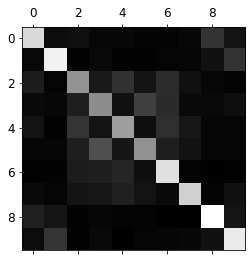

In [0]:
plt.matshow(cm_ovr, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Let's do SGD (Stochastic Gradient Descent) classifier this time. It takes a very long time.

In [0]:
sgd_clf.fit(X_train_2d, y_train)
sgd_clf.predict([some_pic])

array([6], dtype=uint8)

Well, it gives a right result.

In [0]:
y_pred = sgd_clf.predict(X_test_2d)
accuracy_score(y_test, y_pred)

0.3242

Let's use PCA reduced the data.

In [0]:
sgd_clf.fit(X_train_PCA_reduced, y_train)
sgd_clf.predict(test_reduced)

array([7], dtype=uint8)

It took much less time, but with a wrong prediction.

In [0]:
y_pred = sgd_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.3044

Overall accuracy for SGD with PCA reduced data is 30.44% with 2% accuracy down and much speed up.

In [0]:
sgd_score = sgd_clf.decision_function(test_reduced)
sgd_score

array([[-2.19250577, -1.60315651, -1.42426416, -0.91211381, -1.24990739,
        -1.31241862, -1.10547433, -0.29982903, -5.17253513, -2.60228213]])

In [0]:
np.argmax(sgd_score)

7

In [0]:
cross_val_score(sgd_clf, X_train_PCA_reduced, y_train, cv=3, scoring="accuracy")

array([0.32039359, 0.30563389, 0.3124325 ])

In [0]:
precision_score(y_test, y_pred, average='weighted')

0.35793458597844674

In [0]:
recall_score(y_test, y_pred, average='weighted')

0.3668

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_PCA_reduced.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.32177356, 0.31271375, 0.3149526 ])

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[1965,  303,  327,  237,  158,  193,  214,  298,  835,  470],
       [ 298, 2005,  226,  212,  162,  157,  333,  255,  444,  908],
       [ 504,  250,  941,  436,  471,  472,  817,  619,  276,  214],
       [ 301,  359,  531,  811,  402,  651,  881,  413,  294,  357],
       [ 316,  236,  702,  410,  782,  449, 1000,  737,  174,  194],
       [ 292,  340,  537,  696,  386, 1018,  679,  545,  270,  237],
       [ 154,  263,  425,  517,  390,  428, 2139,  360,  113,  211],
       [ 293,  260,  407,  342,  440,  325,  384, 1858,  203,  488],
       [ 818,  370,  228,  189,  127,  174,  139,  133, 2272,  550],
       [ 323,  864,  191,  161,  162,  174,  308,  289,  495, 2033]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


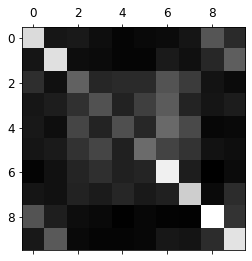

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

Let's focus the plot on the errors

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


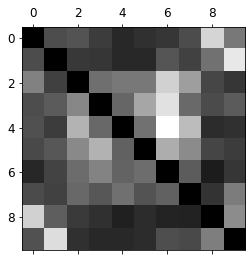

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

K-Nearest Neighbors Classifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_2d, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
knn_clf.predict([some_pic])

array([[False, False]])

In [0]:
noise = np.random.randint(0, 100, (len(X_train_2d), 3072))
X_train_mod = X_train_2d + noise/255
noise = np.random.randint(0, 100, (len(X_test_2d), 3072))
X_test_mod = X_test_2d + noise/255
y_train_mod = X_train_2d
y_test_mod = X_test_2d

In [0]:
def plot_pic(data):
    image = data.reshape(32, 32,3)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving figure noisy_pic_example_plot


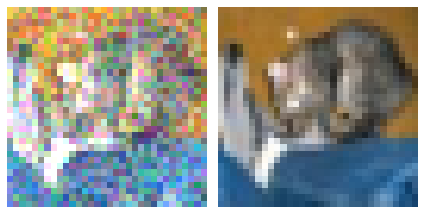

In [0]:
some_index = 0
plt.subplot(121); plot_pic(X_test_mod[some_index])
plt.subplot(122); plot_pic(y_test_mod[some_index])
save_fig("noisy_pic_example_plot")
plt.show()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train_2d, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [0]:
y_knn_pred = knn_clf.predict(X_test_2d)

Another very very long time cell above. Over half an hour, in addition, it consumes a large amount of memory.

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.3542

Overall accuracy is 35.42%

In [0]:
conf_knn = confusion_matrix(y_test, y_knn_pred)
conf_knn


array([[491,   8, 105,  14,  60,   9,  40,  10, 254,   9],
       [ 90, 204,  87,  43, 162,  53,  71,  24, 233,  33],
       [ 87,   1, 386,  53, 258,  47,  87,  13,  61,   7],
       [ 47,   5, 174, 212, 185, 136, 136,  38,  56,  11],
       [ 50,   1, 212,  39, 502,  34,  70,  22,  68,   2],
       [ 39,   1, 175, 138, 177, 277, 106,  19,  61,   7],
       [ 14,   1, 202,  70, 294,  44, 329,   8,  36,   2],
       [ 71,   7, 137,  48, 263,  59,  75, 266,  68,   6],
       [110,  11,  39,  37,  61,  15,  19,  11, 689,   8],
       [111,  52,  74,  63, 116,  32,  68,  41, 257, 186]])

Saving figure confusion_matrix_plot


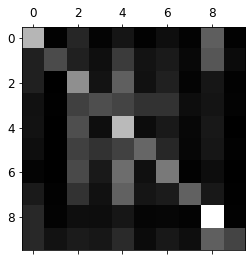

In [0]:
plt.matshow(conf_knn, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [0]:
precision_score(y_test, y_knn_pred, average='weighted')

0.4305535260035026

In [0]:
recall_score(y_test, y_knn_pred, average='weighted')

0.3542

So far, the best overall accuracy is Random Forrest without PCA. It has 46.54% accuracy. After using PCA reduction, the accuracy dropped a little bit to 43.68%.

All other classifiers, including SVM,SGD,OVR,KNN, have overall accuracy below 40%.


With the time limitation, mutilclass precison  vs recall chart and ROC curve was not able to apply to all classifiers.


Many cells takes a very long time to run, e.g. cross-validation, OvR, and KNN. It will take half an hour to 2 hours for a single cell to run.
    
Once get disconnected, willingly or not, you'll have to run all the previous cells again which consumes significant amount of time.
